### ssGSEA analysis on data from TCGA-SKCM dataset (skin cutaneous melanoma)

In [74]:
library(matrixStats)
library(circlize)
library(ComplexHeatmap)
library(data.table)
library(SummarizedExperiment)
library(S4Vectors)
library(GenomicRanges)
library(IRanges)
library(dplyr)

In [75]:
#set working directory (location where TCGA data is stored)
setwd("/scratch/user/s4436039/TCGA_Data")

In [76]:
# load in data (data was previously downloaded using the TCGAbiolinks package in R and saved as an RDS object)
TCGA_SKCM <- readRDS("TCGA_SKCM.rds")
TCGA_SKCM
summary(TCGA_SKCM)

class: RangedSummarizedExperiment 
dim: 60660 473 
metadata(1): data_release
assays(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand
rownames(60660): ENSG00000000003.15 ENSG00000000005.6 ...
  ENSG00000288674.1 ENSG00000288675.1
rowData names(10): source type ... hgnc_id havana_gene
colnames(473): TCGA-ER-A199-06A-11R-A18T-07
  TCGA-EE-A3J5-06A-11R-A20F-07 ... TCGA-FS-A4F0-06A-11R-A24X-07
  TCGA-GN-A262-06A-11R-A18T-07
colData names(175): barcode patient ... paper_DIPYRIM.C.T.n.C.T..mut
  paper_SHATTERSEEK_Chromothripsis_calls

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [77]:
unique(TCGA_SKCM$sample_type)

[1] "Metastatic"            "Primary Tumor"         "Solid Tissue Normal"  
[4] "Additional Metastatic"

In [78]:
table(colData(TCGA_SKCM)$sample_type)


Additional Metastatic            Metastatic         Primary Tumor 
                    1                   368                   103 
  Solid Tissue Normal 
                    1 

In [79]:
# Subset object
primary <- TCGA_SKCM[, colData(TCGA_SKCM)$sample_type == "Primary Tumor"]

In [80]:
table(colData(primary)$sample_type)


Primary Tumor 
          103 

In [81]:
summary(primary)

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [82]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [83]:
#view the different assays stored
assays(primary)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [84]:
#for this analysis using the tpm_unstrand assay 
dim(assays(primary)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(primary)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660   103

,TCGA-BF-A5ES-01A-11R-A27Q-07,TCGA-EB-A3XF-01A-31R-A239-07,TCGA-EB-A57M-01A-51R-A311-07
ENSG00000000003.15,13.9392,40.4117,18.4980
ENSG00000000005.6,0.0512,0.0546,0.3237
ENSG00000000419.13,51.3833,101.0688,47.7959


In [85]:
#convert to matrix
data = as.matrix(data)

In [86]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [87]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
  0.817   0.104   0.925 

In [88]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-BF-A5ES-01A-11R-A27Q-07,0.3882478
TCGA-EB-A3XF-01A-31R-A239-07,0.3801904
TCGA-EB-A57M-01A-51R-A311-07,0.3809149
TCGA-BF-AAP8-01A-11R-A40A-07,0.3629182
TCGA-ER-A2NF-01A-11R-A18T-07,0.3788546
TCGA-ER-A194-01A-11R-A18U-07,0.3675081


In [89]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]   1 103

TCGA-BF-A5ES-01A-11R-A27Q-07 TCGA-EB-A3XF-01A-31R-A239-07 
                   1.2780033                    0.5317625 
TCGA-EB-A57M-01A-51R-A311-07 TCGA-BF-AAP8-01A-11R-A40A-07 
                   0.5988608                   -1.0679094 
TCGA-ER-A2NF-01A-11R-A18T-07 
                   0.4080422

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [90]:
#to view the types of data stored for each sample 
colnames(colData(primary))

[1] "barcode"                                                                                       
  [2] "patient"                                                                                       
  [3] "sample"                                                                                        
  [4] "shortLetterCode"                                                                               
  [5] "definition"                                                                                    
  [6] "sample_submitter_id"                                                                           
  [7] "sample_type_id"                                                                                
  [8] "tumor_descriptor"                                                                              
  [9] "sample_id"                                                                                     
 [10] "sample_type"                                                                                   
 [11] "composition"                                                                                   
 [12] "days_to_collection"                                                                            
 [13] "state"                                                                                         
 [14] "initial_weight"                                                                                
 [15] "preservation_method"                                                                           
 [16] "pathology_report_uuid"                                                                         
 [17] "submitter_id"                                                                                  
 [18] "oct_embedded"                                                                                  
 [19] "specimen_type"                                                                                 
 [20] "is_ffpe"                                                                                       
 [21] "tissue_type"                                                                                   
 [22] "synchronous_malignancy"                                                                        
 [23] "ajcc_pathologic_stage"                                                                         
 [24] "days_to_diagnosis"                                                                             
 [25] "treatments"                                                                                    
 [26] "last_known_disease_status"                                                                     
 [27] "tissue_or_organ_of_origin"                                                                     
 [28] "days_to_last_follow_up"                                                                        
 [29] "age_at_diagnosis"                                                                              
 [30] "primary_diagnosis"                                                                             
 [31] "prior_malignancy"                                                                              
 [32] "year_of_diagnosis"                                                                             
 [33] "prior_treatment"                                                                               
 [34] "ajcc_staging_system_edition"                                                                   
 [35] "ajcc_pathologic_t"                                                                             
 [36] "morphology"                                                                                    
 [37] "ajcc_pathologic_n"                                                                             
 [38] "ajcc_pathologic_m"                                                                             
 [39] "classification_of_tumor"                                                         

In [91]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 103   1

,mat
TCGA-BF-A5ES-01A-11R-A27Q-07,1.2780033
TCGA-EB-A3XF-01A-31R-A239-07,0.5317625
TCGA-EB-A57M-01A-51R-A311-07,0.5988608
TCGA-BF-AAP8-01A-11R-A40A-07,-1.0679094
TCGA-ER-A2NF-01A-11R-A18T-07,0.4080422
TCGA-ER-A194-01A-11R-A18U-07,-0.6428138


In [92]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(primary)$days_to_death
names(death_days) <- row.names(colData(primary))
followup_days <- colData(primary)$days_to_last_follow_up
names(followup_days) <- row.names(colData(primary))
status <- colData(primary)$vital_status
names(status) <- row.names(colData(primary))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-BF-A5ES-01A-11R-A27Q-07,1.27800330783343,490,Alive,NA
TCGA-EB-A3XF-01A-31R-A239-07,0.53176254355142,278,Alive,NA
TCGA-EB-A57M-01A-51R-A311-07,0.598860825592122,399,Dead,472
TCGA-BF-AAP8-01A-11R-A40A-07,-1.06790937000583,447,Alive,NA
TCGA-ER-A2NF-01A-11R-A18T-07,0.408042223171928,498,Dead,877
TCGA-ER-A194-01A-11R-A18U-07,-0.642813844672632,NA,Dead,1354


In [93]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-BF-A5ES-01A-11R-A27Q-07,1.27800330783343,490,Alive,NA,FALSE
TCGA-EB-A3XF-01A-31R-A239-07,0.53176254355142,278,Alive,NA,FALSE
TCGA-EB-A57M-01A-51R-A311-07,0.598860825592122,399,Dead,472,TRUE
TCGA-BF-AAP8-01A-11R-A40A-07,-1.06790937000583,447,Alive,NA,FALSE
TCGA-ER-A2NF-01A-11R-A18T-07,0.408042223171928,498,Dead,877,TRUE
TCGA-ER-A194-01A-11R-A18U-07,-0.642813844672632,NA,Dead,1354,TRUE


In [94]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-BF-A5ES-01A-11R-A27Q-07,1.27800330783343,490,Alive,NA,FALSE,490
TCGA-EB-A3XF-01A-31R-A239-07,0.53176254355142,278,Alive,NA,FALSE,278
TCGA-EB-A57M-01A-51R-A311-07,0.598860825592122,399,Dead,472,TRUE,472
TCGA-BF-AAP8-01A-11R-A40A-07,-1.06790937000583,447,Alive,NA,FALSE,447
TCGA-ER-A2NF-01A-11R-A18T-07,0.408042223171928,498,Dead,877,TRUE,877
TCGA-ER-A194-01A-11R-A18U-07,-0.642813844672632,NA,Dead,1354,TRUE,1354


In [95]:
# load packages needed for survival analysis
library(survival)
library(survminer)

In [96]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-BF-A5ES-01A-11R-A27Q-07,1.27800330783343,490,Alive,NA,FALSE,490,Top 33%
TCGA-EB-A3XF-01A-31R-A239-07,0.53176254355142,278,Alive,NA,FALSE,278,Top 33%
TCGA-EB-A57M-01A-51R-A311-07,0.598860825592122,399,Dead,472,TRUE,472,Top 33%
TCGA-BF-AAP8-01A-11R-A40A-07,-1.06790937000583,447,Alive,NA,FALSE,447,Middle
TCGA-ER-A2NF-01A-11R-A18T-07,0.408042223171928,498,Dead,877,TRUE,877,Top 33%
TCGA-ER-A194-01A-11R-A18U-07,-0.642813844672632,NA,Dead,1354,TRUE,1354,Middle


In [97]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-BF-A5ES-01A-11R-A27Q-07,1.27800330783343,490,Alive,NA,FALSE,490,Top 33%
TCGA-EB-A3XF-01A-31R-A239-07,0.53176254355142,278,Alive,NA,FALSE,278,Top 33%
TCGA-EB-A57M-01A-51R-A311-07,0.598860825592122,399,Dead,472,TRUE,472,Top 33%
TCGA-ER-A2NF-01A-11R-A18T-07,0.408042223171928,498,Dead,877,TRUE,877,Top 33%
TCGA-EB-A5FP-01A-11R-A27Q-07,-0.385305654304283,6,Dead,454,TRUE,454,Bottom 33%
TCGA-XV-AAZV-01A-11R-A40A-07,1.49682863428979,412,Alive,NA,FALSE,412,Top 33%


In [98]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

                   n events median 0.95LCL 0.95UCL
strata=Bottom 33% 20      4   1070      NA      NA
strata=Top 33%    35      9    877     821      NA

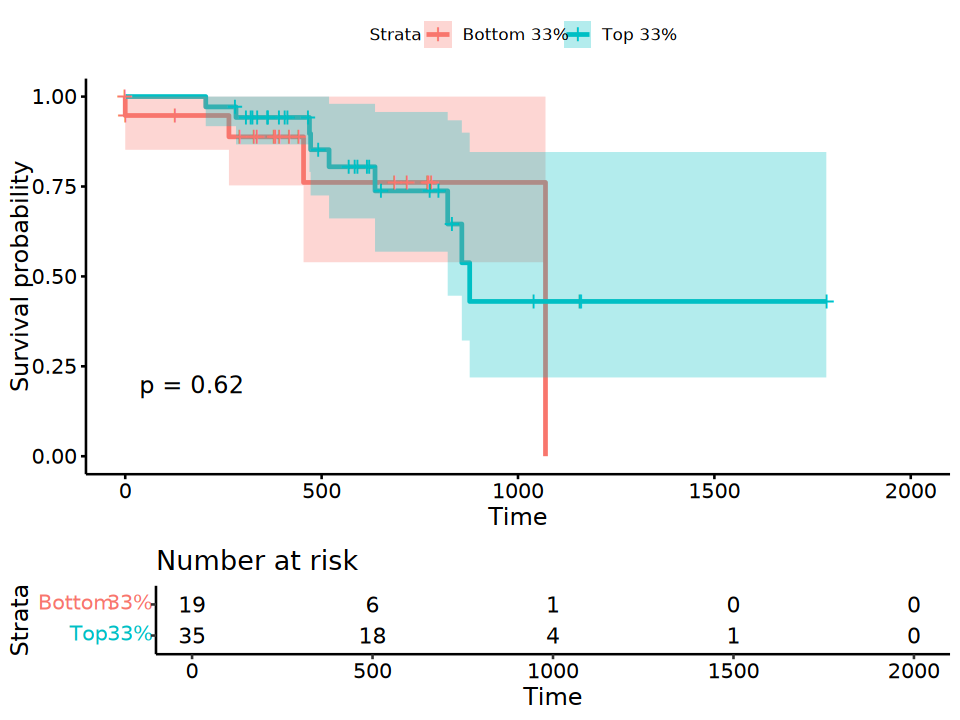

In [99]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)

# Repeat on mets

In [100]:
table(colData(TCGA_SKCM)$sample_type)


Additional Metastatic            Metastatic         Primary Tumor 
                    1                   368                   103 
  Solid Tissue Normal 
                    1 

In [101]:
# Subset object
mets <- TCGA_SKCM[, colData(TCGA_SKCM)$sample_type == "Metastatic"]

In [102]:
table(colData(mets)$sample_type)


Metastatic 
       368 

In [103]:
summary(mets)

[1] "RangedSummarizedExperiment object of length 60660 with 10 metadata columns"

In [104]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [105]:
#view the different assays stored
assays(mets)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [106]:
#for this analysis using the tpm_unstrand assay 
dim(assays(mets)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(mets)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660   368

,TCGA-ER-A199-06A-11R-A18T-07,TCGA-EE-A3J5-06A-11R-A20F-07,TCGA-EE-A2ME-06A-11R-A18T-07
ENSG00000000003.15,19.6288,32.8908,12.9416
ENSG00000000005.6,0.0461,0.0000,0.2589
ENSG00000000419.13,78.7257,124.2221,65.2906


In [107]:
#convert to matrix
data = as.matrix(data)

In [108]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [109]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
  2.777   0.703   3.495 

In [110]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-ER-A199-06A-11R-A18T-07,0.4040007
TCGA-EE-A3J5-06A-11R-A20F-07,0.3863038
TCGA-EE-A2ME-06A-11R-A18T-07,0.4130965
TCGA-D3-A8GE-06A-11R-A37K-07,0.3772395
TCGA-EE-A2MG-06A-11R-A18T-07,0.4041326
TCGA-EE-A2MR-06A-11R-A18S-07,0.4081942


In [111]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]   1 368

TCGA-ER-A199-06A-11R-A18T-07 TCGA-EE-A3J5-06A-11R-A20F-07 
                   1.4677809                    0.3217850 
TCGA-EE-A2ME-06A-11R-A18T-07 TCGA-D3-A8GE-06A-11R-A37K-07 
                   2.0567981                   -0.2651891 
TCGA-EE-A2MG-06A-11R-A18T-07 
                   1.4763237

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [112]:
#to view the types of data stored for each sample 
colnames(colData(mets))

[1] "barcode"                                                                                       
  [2] "patient"                                                                                       
  [3] "sample"                                                                                        
  [4] "shortLetterCode"                                                                               
  [5] "definition"                                                                                    
  [6] "sample_submitter_id"                                                                           
  [7] "sample_type_id"                                                                                
  [8] "tumor_descriptor"                                                                              
  [9] "sample_id"                                                                                     
 [10] "sample_type"                                                                                   
 [11] "composition"                                                                                   
 [12] "days_to_collection"                                                                            
 [13] "state"                                                                                         
 [14] "initial_weight"                                                                                
 [15] "preservation_method"                                                                           
 [16] "pathology_report_uuid"                                                                         
 [17] "submitter_id"                                                                                  
 [18] "oct_embedded"                                                                                  
 [19] "specimen_type"                                                                                 
 [20] "is_ffpe"                                                                                       
 [21] "tissue_type"                                                                                   
 [22] "synchronous_malignancy"                                                                        
 [23] "ajcc_pathologic_stage"                                                                         
 [24] "days_to_diagnosis"                                                                             
 [25] "treatments"                                                                                    
 [26] "last_known_disease_status"                                                                     
 [27] "tissue_or_organ_of_origin"                                                                     
 [28] "days_to_last_follow_up"                                                                        
 [29] "age_at_diagnosis"                                                                              
 [30] "primary_diagnosis"                                                                             
 [31] "prior_malignancy"                                                                              
 [32] "year_of_diagnosis"                                                                             
 [33] "prior_treatment"                                                                               
 [34] "ajcc_staging_system_edition"                                                                   
 [35] "ajcc_pathologic_t"                                                                             
 [36] "morphology"                                                                                    
 [37] "ajcc_pathologic_n"                                                                             
 [38] "ajcc_pathologic_m"                                                                             
 [39] "classification_of_tumor"                                                         

In [113]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 368   1

,mat
TCGA-ER-A199-06A-11R-A18T-07,1.4677809
TCGA-EE-A3J5-06A-11R-A20F-07,0.3217850
TCGA-EE-A2ME-06A-11R-A18T-07,2.0567981
TCGA-D3-A8GE-06A-11R-A37K-07,-0.2651891
TCGA-EE-A2MG-06A-11R-A18T-07,1.4763237
TCGA-EE-A2MR-06A-11R-A18S-07,1.7393387


In [114]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(mets)$days_to_death
names(death_days) <- row.names(colData(mets))
followup_days <- colData(mets)$days_to_last_follow_up
names(followup_days) <- row.names(colData(mets))
status <- colData(mets)$vital_status
names(status) <- row.names(colData(mets))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-ER-A199-06A-11R-A18T-07,1.46778088036528,NA,Dead,279
TCGA-EE-A3J5-06A-11R-A20F-07,0.321785015048965,NA,Dead,1124
TCGA-EE-A2ME-06A-11R-A18T-07,2.05679805256497,NA,Dead,3141
TCGA-D3-A8GE-06A-11R-A37K-07,-0.265189065037172,804,Alive,NA
TCGA-EE-A2MG-06A-11R-A18T-07,1.47632372103125,NA,Dead,3139
TCGA-EE-A2MR-06A-11R-A18S-07,1.73933873003411,4088,Alive,NA


In [115]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-ER-A199-06A-11R-A18T-07,1.46778088036528,NA,Dead,279,TRUE
TCGA-EE-A3J5-06A-11R-A20F-07,0.321785015048965,NA,Dead,1124,TRUE
TCGA-EE-A2ME-06A-11R-A18T-07,2.05679805256497,NA,Dead,3141,TRUE
TCGA-D3-A8GE-06A-11R-A37K-07,-0.265189065037172,804,Alive,NA,FALSE
TCGA-EE-A2MG-06A-11R-A18T-07,1.47632372103125,NA,Dead,3139,TRUE
TCGA-EE-A2MR-06A-11R-A18S-07,1.73933873003411,4088,Alive,NA,FALSE


In [116]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-ER-A199-06A-11R-A18T-07,1.46778088036528,NA,Dead,279,TRUE,279
TCGA-EE-A3J5-06A-11R-A20F-07,0.321785015048965,NA,Dead,1124,TRUE,1124
TCGA-EE-A2ME-06A-11R-A18T-07,2.05679805256497,NA,Dead,3141,TRUE,3141
TCGA-D3-A8GE-06A-11R-A37K-07,-0.265189065037172,804,Alive,NA,FALSE,804
TCGA-EE-A2MG-06A-11R-A18T-07,1.47632372103125,NA,Dead,3139,TRUE,3139
TCGA-EE-A2MR-06A-11R-A18S-07,1.73933873003411,4088,Alive,NA,FALSE,4088


In [117]:
# load packages needed for survival analysis
library(survival)
library(survminer)

In [118]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.46778088036528,NA,Dead,279,TRUE,279,Top 33%
TCGA-EE-A3J5-06A-11R-A20F-07,0.321785015048965,NA,Dead,1124,TRUE,1124,Middle
TCGA-EE-A2ME-06A-11R-A18T-07,2.05679805256497,NA,Dead,3141,TRUE,3141,Top 33%
TCGA-D3-A8GE-06A-11R-A37K-07,-0.265189065037172,804,Alive,NA,FALSE,804,Bottom 33%
TCGA-EE-A2MG-06A-11R-A18T-07,1.47632372103125,NA,Dead,3139,TRUE,3139,Top 33%
TCGA-EE-A2MR-06A-11R-A18S-07,1.73933873003411,4088,Alive,NA,FALSE,4088,Top 33%


In [119]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.46778088036528,NA,Dead,279,TRUE,279,Top 33%
TCGA-EE-A2ME-06A-11R-A18T-07,2.05679805256497,NA,Dead,3141,TRUE,3141,Top 33%
TCGA-D3-A8GE-06A-11R-A37K-07,-0.265189065037172,804,Alive,NA,FALSE,804,Bottom 33%
TCGA-EE-A2MG-06A-11R-A18T-07,1.47632372103125,NA,Dead,3139,TRUE,3139,Top 33%
TCGA-EE-A2MR-06A-11R-A18S-07,1.73933873003411,4088,Alive,NA,FALSE,4088,Top 33%
TCGA-FR-A44A-06A-11R-A24X-07,1.3381233803239,5299,Alive,NA,FALSE,5299,Top 33%


In [120]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

   4 observations deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
strata=Bottom 33%  62     34   3453    2028    6164
strata=Top 33%    123     55   3139    2192      NA

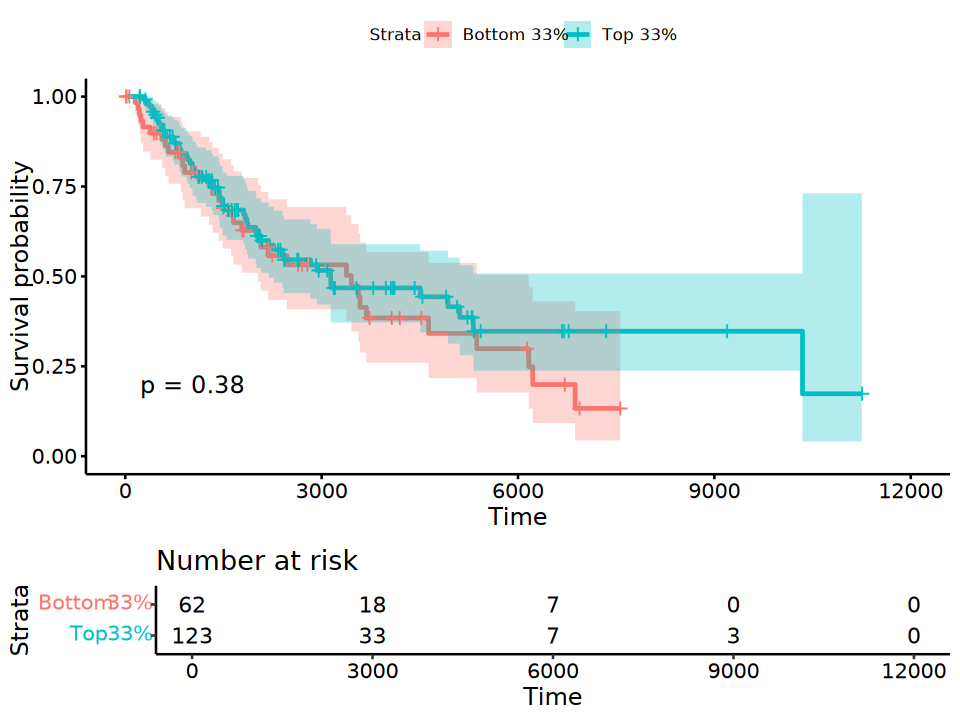

In [121]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)

# repeat all data grouped together: 

In [122]:
table(colData(TCGA_SKCM)$sample_type)


Additional Metastatic            Metastatic         Primary Tumor 
                    1                   368                   103 
  Solid Tissue Normal 
                    1 

In [123]:
#define SSGSEA Function
#function from https://rpubs.com/pranali018/SSGSEA  

ssgsea = function(X, gene_sets, alpha = 0.25, scale = T, norm = F, single = T) {
  row_names = rownames(X)
  num_genes = nrow(X)
  gene_sets = lapply(gene_sets, function(genes) {which(row_names %in% genes)})
  
  # Ranks for genes
  R = matrixStats::colRanks(X, preserveShape = T, ties.method = 'average')
  
  # Calculate enrichment score (es) for each sample (column)
  es = apply(R, 2, function(R_col) {
    gene_ranks = order(R_col, decreasing = TRUE)
    
    # Calc es for each gene set
    es_sample = sapply(gene_sets, function(gene_set_idx) {
      # pos: match (within the gene set)
      # neg: non-match (outside the gene set)
      indicator_pos = gene_ranks %in% gene_set_idx
      indicator_neg = !indicator_pos
      
      rank_alpha  = (R_col[gene_ranks] * indicator_pos) ^ alpha
      
      step_cdf_pos = cumsum(rank_alpha)    / sum(rank_alpha)
      step_cdf_neg = cumsum(indicator_neg) / sum(indicator_neg)
      
      step_cdf_diff = step_cdf_pos - step_cdf_neg
      
      # Normalize by gene number
      if (scale) step_cdf_diff = step_cdf_diff / num_genes
      
      # Use ssGSEA or not
      if (single) {
        sum(step_cdf_diff)
      } else {
        step_cdf_diff[which.max(abs(step_cdf_diff))]
      }
    })
    unlist(es_sample)
  })
  
  if (length(gene_sets) == 1) es = matrix(es, nrow = 1)
  
  # Normalize by absolute diff between max and min
  if (norm) es = es / diff(range(es))
  
  # Prepare output
  rownames(es) = names(gene_sets)
  colnames(es) = colnames(X)
  return(es)
}


In [124]:
#view the different assays stored
assays(TCGA_SKCM)

List of length 6
names(6): unstranded stranded_first ... fpkm_unstrand fpkm_uq_unstrand

In [125]:
#for this analysis using the tpm_unstrand assay 
dim(assays(TCGA_SKCM)$tpm_unstrand)
#set data to tpm_unstand assay for this analysis
data <- assays(TCGA_SKCM)$tpm_unstrand
#view data
data[1:3,1:3]

[1] 60660   473

,TCGA-ER-A199-06A-11R-A18T-07,TCGA-EE-A3J5-06A-11R-A20F-07,TCGA-EE-A2ME-06A-11R-A18T-07
ENSG00000000003.15,19.6288,32.8908,12.9416
ENSG00000000005.6,0.0461,0.0000,0.2589
ENSG00000000419.13,78.7257,124.2221,65.2906


In [126]:
#convert to matrix
data = as.matrix(data)

In [127]:
#load in my signature and make it a list (edit this to any signature)
sig <- fread("ag_pos_vs_dll1_deg_limma.csv", select = c("gene_id"))
sig <- sig[1:100,]
sig = as.list(as.data.frame(sig))
head(sig)

$gene_id
  [1] "ENSG00000102962.5"  "ENSG00000104951.16" "ENSG00000198053.12"
  [4] "ENSG00000126353.3"  "ENSG00000171310.11" "ENSG00000180758.12"
  [7] "ENSG00000090104.12" "ENSG00000023445.16" "ENSG00000056558.11"
 [10] "ENSG00000198223.17" "ENSG00000107021.16" "ENSG00000078081.8" 
 [13] "ENSG00000118242.16" "ENSG00000167641.11" "ENSG00000198369.10"
 [16] "ENSG00000112149.10" "ENSG00000136810.13" "ENSG00000172081.14"
 [19] "ENSG00000109320.13" "ENSG00000136111.14" "ENSG00000123374.11"
 [22] "ENSG00000261040.7"  "ENSG00000047365.12" "ENSG00000160445.11"
 [25] "ENSG00000151726.15" "ENSG00000167642.13" "ENSG00000161011.20"
 [28] "ENSG00000204634.13" "ENSG00000101384.12" "ENSG00000278834.1" 
 [31] "ENSG00000156127.8"  "ENSG00000117036.12" "ENSG00000171791.14"
 [34] "ENSG00000068796.19" "ENSG00000075618.18" "ENSG00000118503.15"
 [37] "ENSG00000160050.15" "ENSG00000119508.18" "ENSG00000115165.10"
 [40] "ENSG00000115956.10" "ENSG00000150907.10" "ENSG00000025772.8" 
 [43] "ENSG00000135148.12" "ENSG00000101445.10" "ENSG00000121966.7" 
 [46] "ENSG00000101017.14" "ENSG00000198018.7"  "ENSG00000124762.14"
 [49] "ENSG00000015475.19" "ENSG00000277443.3"  "ENSG00000138166.6" 
 [52] "ENSG00000071054.16" "ENSG00000171552.14" "ENSG00000172183.15"
 [55] "ENSG00000145860.12" "ENSG00000137522.18" "ENSG00000183484.12"
 [58] "ENSG00000138670.18" "ENSG00000197872.11" "ENSG00000084733.11"
 [61] "ENSG00000172292.15" "ENSG00000115594.12" "ENSG00000101109.12"
 [64] "ENSG00000069493.15" "ENSG00000217801.10" "ENSG00000177311.11"
 [67] "ENSG00000159128.15" "ENSG00000120217.14" "ENSG00000136052.9" 
 [70] "ENSG00000118257.17" "ENSG00000164236.12" "ENSG00000169508.7" 
 [73] "ENSG00000163389.12" "ENSG00000128271.22" "ENSG00000102221.14"
 [76] "ENSG00000131773.14" "ENSG00000168036.18" "ENSG00000137571.11"
 [79] "ENSG00000077150.20" "ENSG00000116741.8"  "ENSG00000106803.10"
 [82] "ENSG00000186187.12" "ENSG00000104856.14" "ENSG00000151131.11"
 [85] "ENSG00000168310.11" "ENSG00000273604.2"  "ENSG00000059728.11"
 [88] "ENSG00000111540.16" "ENSG00000117115.13" "ENSG00000136048.14"
 [91] "ENSG00000108389.9"  "ENSG00000103319.12" "ENSG00000111846.19"
 [94] "ENSG00000173166.18" "ENSG00000140379.9"  "ENSG00000101310.17"
 [97] "ENSG00000198355.5"  "ENSG00000163297.17" "ENSG00000166016.6" 
[100] "ENSG00000164484.12"

In [128]:
#Run ssGSEA function
#ssgsea: https://rpubs.com/pranali018/SSGSEA
system.time(assign('res', ssgsea(data, sig, scale = TRUE, norm = FALSE)))

   user  system elapsed 
  3.577   0.622   4.219 

In [129]:
#transpose results
res1 = t(res)
head(res1)

,gene_id
TCGA-ER-A199-06A-11R-A18T-07,0.4040007
TCGA-EE-A3J5-06A-11R-A20F-07,0.3863038
TCGA-EE-A2ME-06A-11R-A18T-07,0.4130965
TCGA-BF-A5ES-01A-11R-A27Q-07,0.3882478
TCGA-D3-A8GE-06A-11R-A37K-07,0.3772395
TCGA-EE-A2MG-06A-11R-A18T-07,0.4041326


In [130]:
#calculate mat (ssGSEA Z score - ssgsea output for comparative analysis)
mat = (res - rowMeans(res))/(rowSds(as.matrix(res)))[row(res)]
dim(mat)
mat[1,1:5] 

[1]   1 473

TCGA-ER-A199-06A-11R-A18T-07 TCGA-EE-A3J5-06A-11R-A20F-07 
                   1.6250178                    0.4326238 
TCGA-EE-A2ME-06A-11R-A18T-07 TCGA-BF-A5ES-01A-11R-A27Q-07 
                   2.2378827                    0.5636116 
TCGA-D3-A8GE-06A-11R-A37K-07 
                  -0.1781152

#### at this point now have a score for each patient with how enriched that sample is for my signature, the ID here is the "barcode"
* next want to see how this score correlates with survival etc

In [131]:
#to view the types of data stored for each sample 
colnames(colData(TCGA_SKCM))

[1] "barcode"                                                                                       
  [2] "patient"                                                                                       
  [3] "sample"                                                                                        
  [4] "shortLetterCode"                                                                               
  [5] "definition"                                                                                    
  [6] "sample_submitter_id"                                                                           
  [7] "sample_type_id"                                                                                
  [8] "tumor_descriptor"                                                                              
  [9] "sample_id"                                                                                     
 [10] "sample_type"                                                                                   
 [11] "composition"                                                                                   
 [12] "days_to_collection"                                                                            
 [13] "state"                                                                                         
 [14] "initial_weight"                                                                                
 [15] "preservation_method"                                                                           
 [16] "pathology_report_uuid"                                                                         
 [17] "submitter_id"                                                                                  
 [18] "oct_embedded"                                                                                  
 [19] "specimen_type"                                                                                 
 [20] "is_ffpe"                                                                                       
 [21] "tissue_type"                                                                                   
 [22] "synchronous_malignancy"                                                                        
 [23] "ajcc_pathologic_stage"                                                                         
 [24] "days_to_diagnosis"                                                                             
 [25] "treatments"                                                                                    
 [26] "last_known_disease_status"                                                                     
 [27] "tissue_or_organ_of_origin"                                                                     
 [28] "days_to_last_follow_up"                                                                        
 [29] "age_at_diagnosis"                                                                              
 [30] "primary_diagnosis"                                                                             
 [31] "prior_malignancy"                                                                              
 [32] "year_of_diagnosis"                                                                             
 [33] "prior_treatment"                                                                               
 [34] "ajcc_staging_system_edition"                                                                   
 [35] "ajcc_pathologic_t"                                                                             
 [36] "morphology"                                                                                    
 [37] "ajcc_pathologic_n"                                                                             
 [38] "ajcc_pathologic_m"                                                                             
 [39] "classification_of_tumor"                                                         

In [132]:
#change column name
mat <- t(mat)
dim(mat)
colnames(mat) <- c("mat")
head(mat)

[1] 473   1

,mat
TCGA-ER-A199-06A-11R-A18T-07,1.6250178
TCGA-EE-A3J5-06A-11R-A20F-07,0.4326238
TCGA-EE-A2ME-06A-11R-A18T-07,2.2378827
TCGA-BF-A5ES-01A-11R-A27Q-07,0.5636116
TCGA-D3-A8GE-06A-11R-A37K-07,-0.1781152
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065


In [133]:
#now look at days to death, plot K-M curved grouped by groups of mat score 
###following this tutorial: https://www.youtube.com/watch?v=DnygUTAZFmM

#making a matrix with all the data I need
death_days <- colData(TCGA_SKCM)$days_to_death
names(death_days) <- row.names(colData(TCGA_SKCM))
followup_days <- colData(TCGA_SKCM)$days_to_last_follow_up
names(followup_days) <- row.names(colData(TCGA_SKCM))
status <- colData(TCGA_SKCM)$vital_status
names(status) <- row.names(colData(TCGA_SKCM))

concat_survival <- cbind(mat,followup_days,status,death_days)
colnames(concat_survival) <- c("mat","Days_to_last_follow_up","vital_status","days_to_death")
head(concat_survival) 
concat_survival <- as.data.frame(concat_survival)
#now I have a table with the above variables for each patient

,mat,Days_to_last_follow_up,vital_status,days_to_death
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139


In [134]:
#make a new column that records whether or not deceased, this will be needed for status in survival anakysis (for censoring)
concat_survival$deceased <- ifelse(concat_survival$vital_status == "Alive", FALSE, TRUE)
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased
,<chr>,<chr>,<chr>,<chr>,<lgl>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE


In [135]:
#next need to make a "overall survival" column that is equal to days to death for dead patients and to days to last follow up for patients who are still alive 
concat_survival$overall_survival <- ifelse(concat_survival$vital_status == "Alive",
                                           concat_survival$Days_to_last_follow_up,
                                           concat_survival$days_to_death)

#convert overall_survival to numeric
concat_survival$overall_survival <- as.numeric(concat_survival$overall_survival)

head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE,1124
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139


In [136]:
# load packages needed for survival analysis
library(survival)
library(survminer)

In [137]:
#fitting survival curve - prepare data: 

# for my analysis I wanted to plot top vs bottom third on my KM plot, but could also split 50/50 if you wanted
# make variable for either top 33% or bottom 33% mat score
#calculate 66th percentile (above this is top 33%) and 33rd percentile (below this is bottom 33%)
perc_66 <- quantile(mat, probs = c(0.66))
perc_33 <- quantile(mat, probs = c(0.33))

concat_survival_Full <- concat_survival
concat_survival_Full$strata <- ifelse(concat_survival_Full$mat < perc_33, "Bottom 33%",
                                  ifelse(concat_survival_Full$mat >perc_66, "Top 33%", "Middle"))

head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279,Top 33%
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE,1124,Middle
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141,Top 33%
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490,Top 33%
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804,Bottom 33%
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139,Top 33%


In [138]:
#need to remove middle strata from plot
concat_survival_Full <- concat_survival_Full %>% filter(strata %in% c("Top 33%", "Bottom 33%"))
head(concat_survival_Full)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,strata
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279,Top 33%
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141,Top 33%
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490,Top 33%
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804,Bottom 33%
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139,Top 33%
TCGA-EE-A2MR-06A-11R-A18S-07,1.90757028928521,4088,Alive,NA,FALSE,4088,Top 33%


In [139]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ strata, data = concat_survival_Full)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ strata, 
    data = concat_survival_Full)

   3 observations deleted due to missingness 
                    n events median 0.95LCL 0.95UCL
strata=Bottom 33%  85     43   2028    1429    3564
strata=Top 33%    159     63   3141    2402    6590

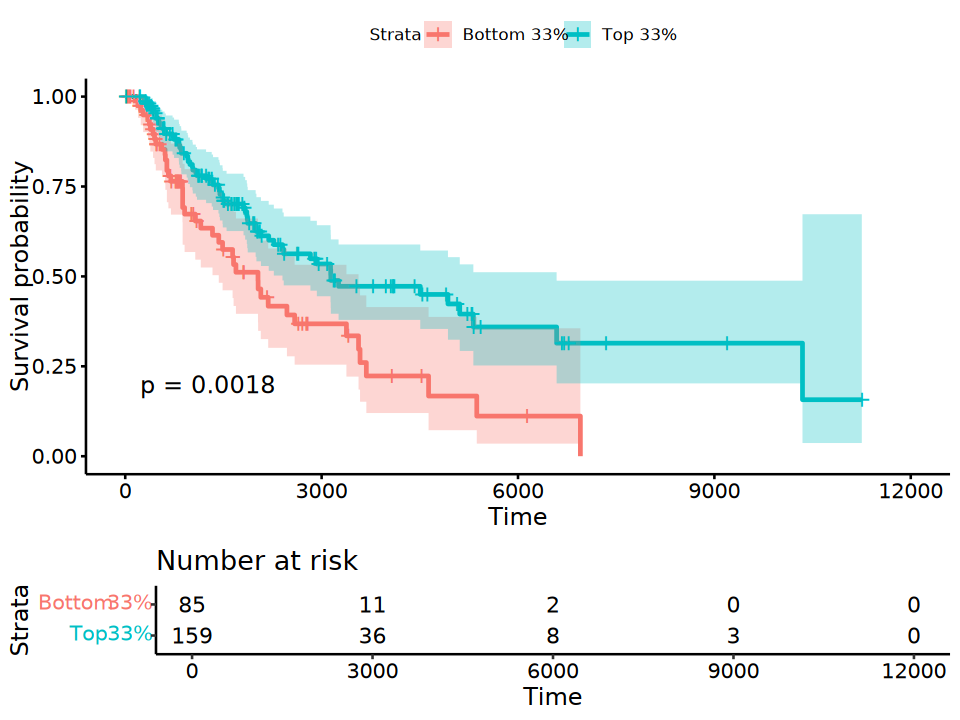

In [140]:
#generate survival plot
options(repr.plot.height=6, repr.plot.width=8)
ggsurvplot(fit,
           data = concat_survival_Full,
           pval = T,
           risk.table = T,
           conf.int = TRUE)

## Plot based on primary vs mets

In [141]:
head(concat_survival)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE,1124
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139


In [142]:
sample_type <- colData(TCGA_SKCM)$sample_type
names(sample_type) <- row.names(colData(TCGA_SKCM))

concat_survival_Type <- cbind(concat_survival,sample_type)
head(concat_survival_Type) 
concat_survival_Type <- as.data.frame(concat_survival_Type)

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,sample_type
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279,Metastatic
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE,1124,Metastatic
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141,Metastatic
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490,Primary Tumor
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804,Metastatic
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139,Metastatic


In [143]:
#Fit survival curve
fit <- survfit(Surv(overall_survival, deceased) ~ sample_type, data = concat_survival_Type)
fit

Call: survfit(formula = Surv(overall_survival, deceased) ~ sample_type, 
    data = concat_survival_Type)

   10 observations deleted due to missingness 
                                    n events median 0.95LCL 0.95UCL
sample_type=Additional Metastatic   1      0     NA      NA      NA
sample_type=Metastatic            358    193   2711    2071    3424
sample_type=Primary Tumor         103     29    877     821      NA
sample_type=Solid Tissue Normal     1      0     NA      NA      NA

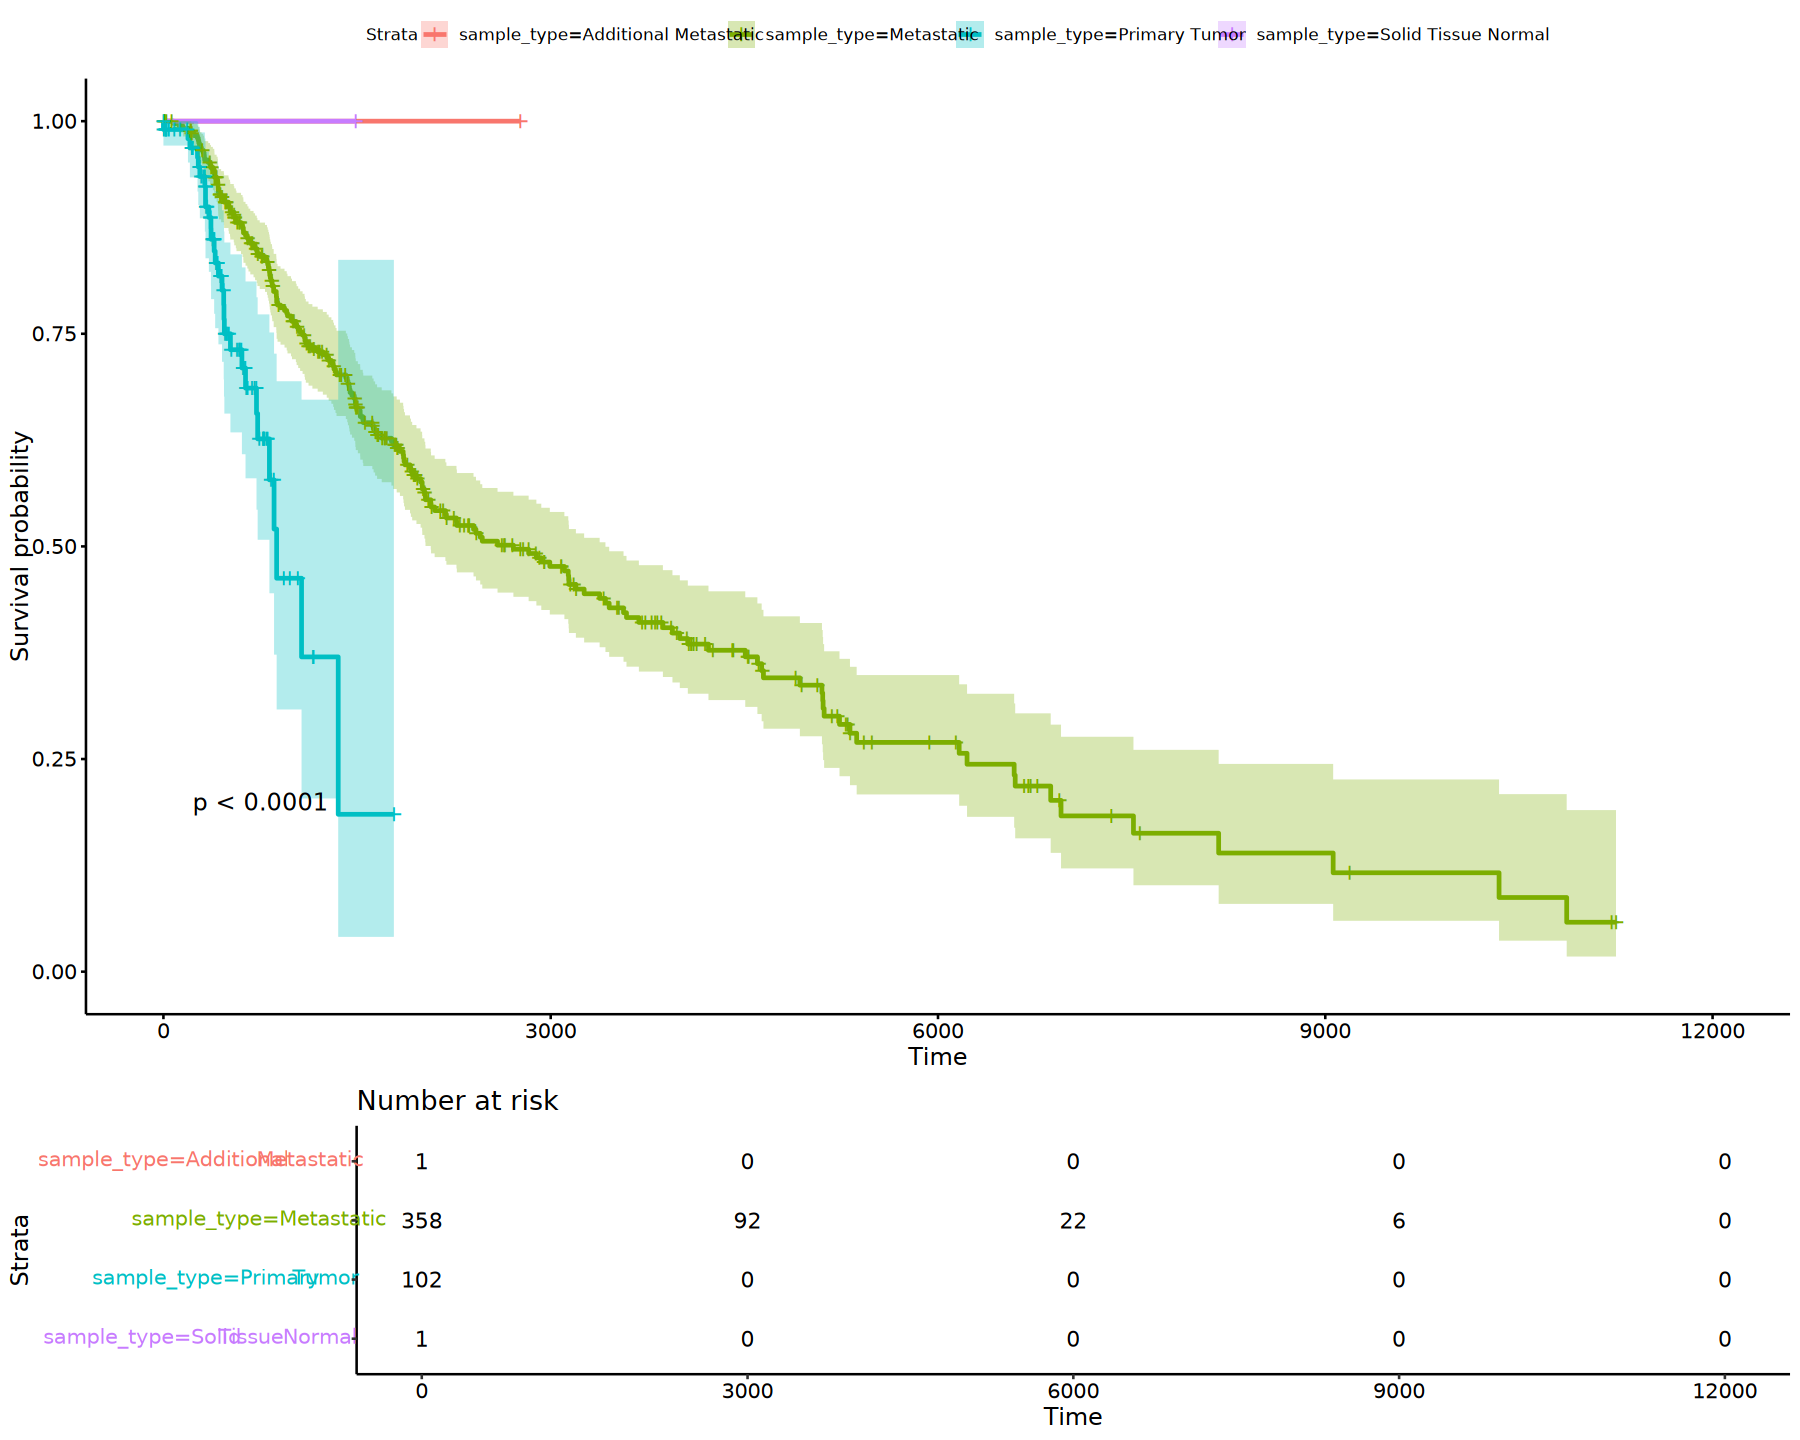

In [146]:
#generate survival plot
options(repr.plot.height=12, repr.plot.width=15)
ggsurvplot(fit,
           data = concat_survival_Type,
           pval = T,
           risk.table = T,
           conf.int = TRUE)

In [147]:
head(concat_survival_Type) 

,mat,Days_to_last_follow_up,vital_status,days_to_death,deceased,overall_survival,sample_type
,<chr>,<chr>,<chr>,<chr>,<lgl>,<dbl>,<chr>
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,NA,Dead,279,TRUE,279,Metastatic
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,NA,Dead,1124,TRUE,1124,Metastatic
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,NA,Dead,3141,TRUE,3141,Metastatic
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,490,Alive,NA,FALSE,490,Primary Tumor
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,804,Alive,NA,FALSE,804,Metastatic
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,NA,Dead,3139,TRUE,3139,Metastatic


In [154]:
head(mat)

,mat
TCGA-ER-A199-06A-11R-A18T-07,1.6250178
TCGA-EE-A3J5-06A-11R-A20F-07,0.4326238
TCGA-EE-A2ME-06A-11R-A18T-07,2.2378827
TCGA-BF-A5ES-01A-11R-A27Q-07,0.5636116
TCGA-D3-A8GE-06A-11R-A37K-07,-0.1781152
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065


In [155]:
sample_type <- colData(TCGA_SKCM)$sample_type
names(sample_type) <- row.names(colData(TCGA_SKCM))
head(sample_type)

TCGA-ER-A199-06A-11R-A18T-07 TCGA-EE-A3J5-06A-11R-A20F-07 
                "Metastatic"                 "Metastatic" 
TCGA-EE-A2ME-06A-11R-A18T-07 TCGA-BF-A5ES-01A-11R-A27Q-07 
                "Metastatic"              "Primary Tumor" 
TCGA-D3-A8GE-06A-11R-A37K-07 TCGA-EE-A2MG-06A-11R-A18T-07 
                "Metastatic"                 "Metastatic"

In [156]:
concat_samples <- cbind(mat,sample_type)
colnames(concat_samples) <- c("mat","sample_type")
head(concat_samples)

,mat,sample_type
TCGA-ER-A199-06A-11R-A18T-07,1.625017819701,Metastatic
TCGA-EE-A3J5-06A-11R-A20F-07,0.432623778161379,Metastatic
TCGA-EE-A2ME-06A-11R-A18T-07,2.23788265434119,Metastatic
TCGA-BF-A5ES-01A-11R-A27Q-07,0.563611582796288,Primary Tumor
TCGA-D3-A8GE-06A-11R-A37K-07,-0.178115245264087,Metastatic
TCGA-EE-A2MG-06A-11R-A18T-07,1.6339065361582,Metastatic


In [157]:
concat_samples_df <- as.data.frame(concat_samples)
concat_samples_df$sample_type <- as.factor(concat_samples_df$sample_type)
concat_samples_df$mat <- as.numeric(concat_samples_df$mat)

In [ ]:
library(ggplot2) 

Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”
Warning message:
“Groups with fewer than two datapoints have been dropped.
ℹ Set `drop = FALSE` to consider such groups for position adjustment purposes.”


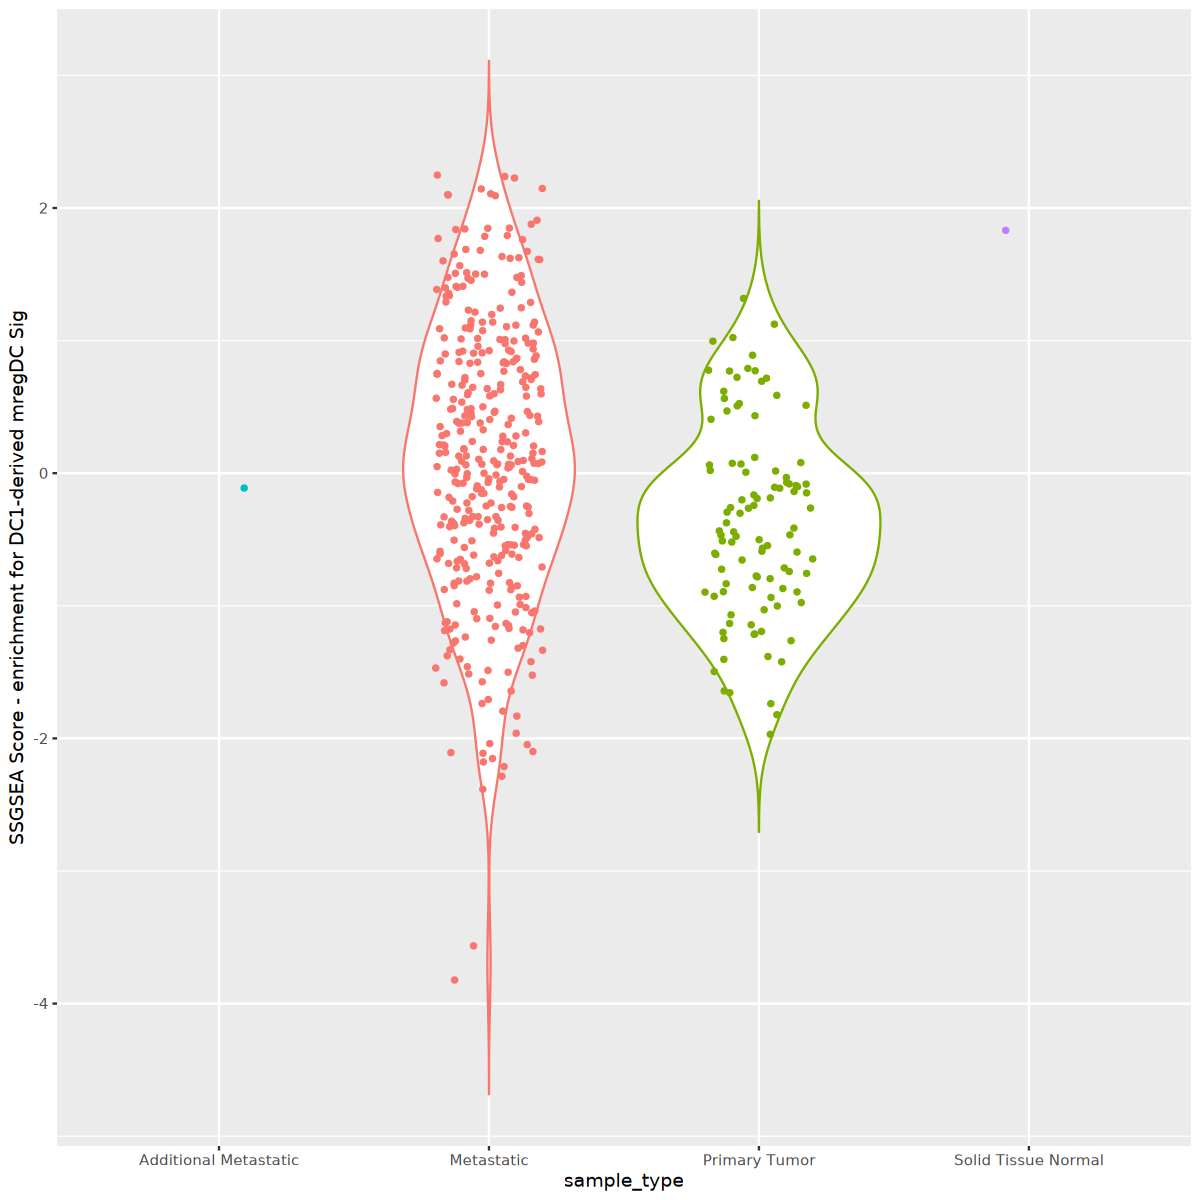

In [159]:
#Make M1 figure
options(repr.plot.height=10, repr.plot.width=10)
v <- ggplot(concat_samples_df, aes(x=sample_type, y=mat, color=sample_type)) + geom_violin(trim=FALSE)
v + geom_jitter(shape=16, position=position_jitter(0.2)) + xlab("sample_type") + ylab("SSGSEA Score - enrichment for DC1-derived mregDC Sig") + theme(legend.position = "none")
